# Question 1

Import packages, load data and instantiate scaler and PCA

In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA

q1_data = pd.read_csv("PADL-Q1.csv")
pca = PCA(n_components=q1_data.shape[1])

Apply PCA to scaled data (scaling is needed for SVD)

In [3]:
q1_data_scaled = scale(q1_data)
q1_pcs = pca.fit_transform(q1_data_scaled)

Check the minimum number of dimensions required to minimize loss of information

In [4]:
total_variance = sum(q1_pcs.var(axis=0))
for num_components in range(1, q1_pcs.shape[1]):
    first_n_comp_variance = (
        sum(q1_pcs[:, 0:num_components].var(axis=0)) / total_variance
    ) * 100
    print(
        f"The first {num_components} principal components correspond to {first_n_comp_variance.round(2)}% of the total variance"
    )

The first 1 principal components correspond to 40.32% of the total variance
The first 2 principal components correspond to 70.24% of the total variance
The first 3 principal components correspond to 81.51% of the total variance
The first 4 principal components correspond to 91.95% of the total variance


Reducing the number of dimensions to four allows for a relatively small loss of information - the 4 components correspond to around 92 percent of the total variance. Therefore, $D_{min}=4$

In [5]:
pca_min_dims = PCA(n_components=4)
q1_pcs_min_dimensions = pca_min_dims.fit_transform(q1_data_scaled)
components = pca_min_dims.components_
components

array([[-0.55608777,  0.16605693, -0.55968369,  0.2074285 , -0.55400277],
       [-0.07616798, -0.68491569, -0.21946827, -0.67209755, -0.15876868],
       [-0.58290436,  0.2674771 , -0.13665832, -0.32308723,  0.68236182],
       [ 0.56104011,  0.48673801, -0.55197578, -0.37899935, -0.00152482]])

In [6]:
np.allclose((q1_data_scaled @ components[2]), q1_pcs_min_dimensions[:, 2])

True

# Question 2

In [7]:
import pandas as pd

q2_data = pd.read_csv("PADL-Q2-train.csv")
q2_data.head()
q2_data_X, q2_data_y = q2_data.drop(columns=["out", "y"]), q2_data["out"]

Split the data into training and testing sets - even though there is a whole separate testing set, reserve a small portion of the training data to make sure the model can generalise

In [54]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    q2_data_X,
    q2_data_y,
    train_size=0.9,
)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((72, 3), (72,), (8, 3), (8,))

In [55]:
from sklearn.feature_selection import r_regression

r_regression(X_train, y_train)

array([-0.31920948, -0.40705909,  0.35807289])

In [56]:
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso, LinearRegression
from sklearn.preprocessing import (
    PolynomialFeatures,
    Normalizer,
    MinMaxScaler,
    StandardScaler,
)
from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score
from sklearn.exceptions import ConvergenceWarning
from scipy.linalg import LinAlgWarning
import warnings

warnings.simplefilter("ignore", category=ConvergenceWarning)
warnings.simplefilter("ignore", category=LinAlgWarning)
num_poly_features = [1, 2, 3, 4, 5]
regularisations = [
    RidgeCV(fit_intercept=True),
    LassoCV(fit_intercept=True),
    Ridge(fit_intercept=True),
    Lasso(fit_intercept=True),
    LinearRegression(fit_intercept=True),
    RidgeCV(fit_intercept=False),
    LassoCV(fit_intercept=False),
    Ridge(fit_intercept=False),
    Lasso(fit_intercept=False),
    LinearRegression(fit_intercept=False),
]
preprocessing = [MinMaxScaler(), StandardScaler(), Normalizer(), PCA(n_components=3)]
best_r2 = -100000
best_model = None
for degree in num_poly_features:
    for reg in regularisations:
        for proc in preprocessing:
            model = make_pipeline(proc, PolynomialFeatures(degree), reg)
            model.fit(X_train, y_train)
            current_r2 = r2_score(y_test, model.predict(X_test))
            if current_r2 > best_r2:
                best_r2 = current_r2
                best_model = model
            print(r2_score(y_test, model.predict(X_test)))

0.4690485769881323
0.4607701449500421
-0.041372824737227365
0.434712212584064
0.4932030773491737
0.49071083523457537
0.1334487649822994
0.3732536255582546
0.46904857698813585
0.49177348993695824
-0.041299135044026825
0.31952376363924095
-0.041380436867785475
-0.041380436867785475
-0.041380436867785475
-0.015017102291696283
0.4953661130612832
0.4953661130612833
0.1660947413897248
0.49536611306128997
0.466349197781484
0.4606819911710902
-0.03951285954750383
0.4347038300087195
0.297198050075013
0.4348387001726747
0.14023951000398827
0.3725897528766413
0.4663491977814853
0.491735711265764
-0.041108883720762046
0.31944004264010184
-0.017382336570189727
-0.017382336570189727
-0.017382336570189727
0.007945044275016522
0.4953661130612834
0.4953661130612833
0.1660947413896876
0.4953661130613094
0.38409987350891694
0.2981817899704874
-0.03861744611193596
0.19765626579260598
0.27381487901224055
0.267254971989632
0.11883570188369219
-0.020510734400116748
0.4585817773767622
0.27107037414183555
-0.0

0.6351540510543634


Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('polynomialfeatures', PolynomialFeatures(degree=3)),
                ('lassocv', LassoCV())])

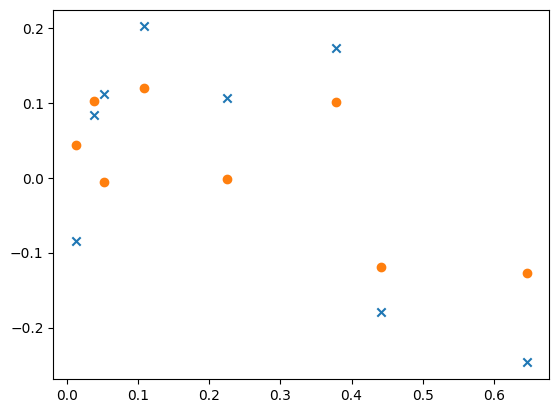

In [58]:
import matplotlib.pyplot as plt

print(best_r2)
best_model.fit(X_train, y_train)
preds = best_model.predict(X_test)
plt.scatter(X_test["z"], y_test, marker="x")
plt.scatter(X_test["z"], preds)
best_model

# Question 3

In [5]:
L = ["gold", "diamond", "robbery", "bank", "police"]

Capture all triplets matching the pattern 'X and Y'

In [6]:
import re

pattern = re.compile(
    r"(?=("  # We need a lookahead because triplets can overlap (e.g. 'X and Y and Z'), normal regex will not capture the second triplet
    r"(?<![a-zA-Z-])"  # Negative lookbehind, ensuring that each triplet starts at the beginning of the first word.
    r"[a-zA-z]+"  # At least one letter (so we don't capture triplets like ', and then')
    r"[\S]*"  # Any number of further letters and/or punctuation except whitespace
    r"\s+"  # At least one whitespace character (newline, tab, space, etc)
    r"[Aa]nd"  # 'And' or 'and'
    r"\s+"  # At least one whitespace character
    r"[a-zA-z]+"  # At least one letter
    r"[\S]*"  # Any number of further letters and/or punctuation
    r"))"
)
print(pattern.findall("testing and trialling"))  # Can capture a single triplet
print(pattern.findall("X and Y and Z"))  # Can capture overlapping triplets
print(pattern.findall("tight-fitting and sleek"))  # Can capture hyphenated words
print(pattern.findall("One And two"))  # Case-insensitive for and
print(
    pattern.findall("This is the end of one sentence. And so, another begins.")
)  # Can capture triplets across sentences
print(
    pattern.findall(
        """
This is the end of one sentence.
And the other is on a new line.
"""
    )
)  # Can handle line breaks
print(
    pattern.findall("What?! And you're only telling me now?")
)  # Can handle other punctuation

['testing and trialling']
['X and Y', 'Y and Z']
['tight-fitting and sleek']
['One And two']
['sentence. And so,']
['sentence.\nAnd the']
["What?! And you're"]


In [7]:
with open("sherlock.txt") as sherlock_file:
    sherlock_full_text = (
        sherlock_file.read()
    )  # full text needed to train the model later
    captured_triplets = pattern.findall(sherlock_full_text)
captured_triplets = [
    re.sub(re.compile(r"\s"), " ", triplet) for triplet in captured_triplets
]  # Replace whitespace (tabs, newlines, etc) characters with spaces

Create a convenience function to compare the length of the shared suffixes: start at the end of each word and iterate backwards until the first pair of letters does not match

In [2]:
def shared_suffix_length(word1: str, word2: str) -> int:
    suffix_length = 0
    for l1, l2 in zip(word1[::-1], word2[::-1]):
        if l1.lower() == l2.lower():
            suffix_length += 1
        else:
            return suffix_length
    return suffix_length


assert shared_suffix_length("bold", "gold") == 3
assert shared_suffix_length("lobster", "mobster") == 6
assert shared_suffix_length("apple", "potato") == 0

Find triplets where the last word rhymes with the target word

In [9]:
rhymes = {}
for word in L:
    rhymes[word] = [
        re.sub(
            "[.,-]", "", triplet
        ).lower()  # remove any punctuation and convert to lowercase for consistency
        for triplet in captured_triplets
        if shared_suffix_length(
            word,
            re.sub(r"\s+", " ", triplet).split(" ")[
                2
            ],  # Remove any repeating whitespace
        )
        >= 3
    ]

In [10]:
rhymes

{'gold': ['away and told', 'rapidly and told', 'indemnify and hold'],
 'diamond': [],
 'robbery': ['delicacy and every',
  'pay and very',
  'ten and every',
  'abbots and archery',
  'police and every',
  'air and scenery',
  'long and very',
  'armchair and cheery',
  'police and very'],
 'bank': ['do and frank', 'mercifully and thank'],
 'police': ['help and advice']}

Load up a pre-trained word2vec model

In [11]:
import nltk
from gensim import downloader as api
from gensim.models import Word2Vec

nltk.download("punkt")

# Load the glove-wiki-gigaword-100 pre-trained word2vec model
model = api.load("glove-wiki-gigaword-100")
sherlock_model = Word2Vec(sherlock_full_text, vector_size=100, min_count=1, epochs=30)
total_examples = sherlock_model.corpus_count
sherlock_model.build_vocab([list(model.key_to_index.keys())], update=True)
sherlock_model.wv.vectors_lockf = np.ones(len(sherlock_model.wv))
sherlock_model.wv.intersect_word2vec_format(
    "~/gensim-data/glove-wiki-gigaword-100/glove-wiki-gigaword-100.gz",
    binary=False,
    lockf=1.0,
)
sherlock_model.train(sherlock_full_text, total_examples=total_examples, epochs=30)

/Users/ivanbar/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
[nltk_data] Downloading package punkt to /Users/ivanbar/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


(14731934, 17861220)

Create a utility function to give a 'similarity score' to a triplet

In [12]:
def similarity_score(triplet: str) -> float:
    first_word = triplet.split(" ")[0]
    last_word = triplet.split(" ")[2]
    return sherlock_model.wv.similarity(first_word, last_word)

In [13]:
for word, triplets in rhymes.items():
    top_5_similar_triplets = sorted(
        triplets,
        key=similarity_score,  # compare using the similarity score function from the above cell
        reverse=True,  # return in descending order
    )[0:5]
    print(f"The best 5 cockney rhymes for word '{word}' are: {top_5_similar_triplets}")

The best 5 cockney rhymes for word 'gold' are: ['away and told', 'rapidly and told', 'indemnify and hold']
The best 5 cockney rhymes for word 'diamond' are: []
The best 5 cockney rhymes for word 'robbery' are: ['long and very', 'ten and every', 'police and every', 'pay and very', 'police and very']
The best 5 cockney rhymes for word 'bank' are: ['do and frank', 'mercifully and thank']
The best 5 cockney rhymes for word 'police' are: ['help and advice']


# Question 4

In [8]:
import torch
from sklearn.model_selection import train_test_split

NUMBER_RANGE = np.arange(-100, 100, 1)

In [9]:
lefts = torch.tensor(NUMBER_RANGE, dtype=torch.float32)
rights = torch.tensor(NUMBER_RANGE, dtype=torch.float32)
X = torch.cartesian_prod(lefts, rights)
y = torch.tensor(np.prod(X.numpy(), axis=1), dtype=torch.float32).unsqueeze(1)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)

In [10]:
model = torch.nn.Sequential(
    torch.nn.Linear(2, 64),
    torch.nn.ReLU(),
    torch.nn.Linear(64, 1),
)
optim = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.L1Loss()
scheduler = torch.optim.lr_scheduler.StepLR(
    optim, step_size=15000, gamma=0.1
)  # The Adam optimizer tends to need some 'help' after the first 15000 epochs, reducing the learning rate for the last bit helps it reduce the loss further.
epochs = 20000

In [9]:
for epoch in range(epochs):
    y_predict = model(X_train)
    loss = criterion(y_train, y_predict)
    optim.zero_grad()
    loss.backward()
    optim.step()
    scheduler.step()
    if not epoch % 1000:
        print(f"Epoch: {epoch}, loss: {loss}")

Epoch: 0, loss: 2497.092529296875
Epoch: 1000, loss: 515.3861694335938
Epoch: 2000, loss: 513.4572143554688
Epoch: 3000, loss: 406.7549133300781
Epoch: 4000, loss: 121.87693786621094
Epoch: 5000, loss: 49.65755844116211
Epoch: 6000, loss: 30.164453506469727
Epoch: 7000, loss: 22.103729248046875
Epoch: 8000, loss: 17.356964111328125
Epoch: 9000, loss: 15.939846992492676
Epoch: 10000, loss: 15.638400077819824
Epoch: 11000, loss: 14.085691452026367
Epoch: 12000, loss: 14.231511116027832
Epoch: 13000, loss: 13.527084350585938
Epoch: 14000, loss: 12.153886795043945
Epoch: 15000, loss: 12.406020164489746
Epoch: 16000, loss: 11.122315406799316
Epoch: 17000, loss: 11.059571266174316
Epoch: 18000, loss: 10.966839790344238
Epoch: 19000, loss: 10.842766761779785


In [19]:
def predict_pair(left, right):
    """
    Convenience method to make a single prediction and output the results using the trained model.
    :param left: the first number to multiply
    :param right: the second number to multiply
    """
    with torch.no_grad():
        prediction = model(torch.tensor([left, right], dtype=torch.float32))
        actual = left * right
        print(
            f"Inputs: {left}, {right}\nPredicted value: {prediction.item()}\nActual value: {actual}\nAbsolute error: {abs(prediction.item() - actual)}"
        )

In [20]:
test_criterion = torch.nn.L1Loss()
with torch.no_grad():
    test_preds = model(X_test)
    print(test_criterion(test_preds, y_test))

tensor(10.7500)


Create some out of range pairs

In [23]:
X_out_of_range = torch.tensor(
    [
        [5, 5000],  # One item out of range (too large)
        [10, -3500],  # One item out of range (too small)
        [500, 1e5],  # Two items out of range (both too large)
        [-400, -500],  # Two items out of range (both too small)
        [1e5, -796],  # Two items out of range (one too large, one too small)
    ]
)
for pair in X_out_of_range:
    predict_pair(*pair)
    print("------------------------")

Inputs: 5.0, 5000.0
Predicted value: -20403.310546875
Actual value: 25000.0
Absolute error: 45403.3125
------------------------
Inputs: 10.0, -3500.0
Predicted value: -12137.529296875
Actual value: -35000.0
Absolute error: 22862.470703125
------------------------
Inputs: 500.0, 100000.0
Predicted value: -353263.0625
Actual value: 50000000.0
Absolute error: 50353264.0
------------------------
Inputs: -400.0, -500.0
Predicted value: 67074.21875
Actual value: 200000.0
Absolute error: 132925.78125
------------------------
Inputs: 100000.0, -796.0
Predicted value: -481882.3125
Actual value: -79600000.0
Absolute error: 79118120.0
------------------------


In [26]:
y_out_of_range = torch.tensor([pair[0] * pair[1] for pair in X_out_of_range]).unsqueeze(
    1
)
preds = model(X_out_of_range)
print(test_criterion(y_out_of_range, preds))

tensor(25934516., grad_fn=<MeanBackward0>)


As seen, the model's predictions outside of the training range are nearly meaningless

# Question 5

In [137]:
from torch.utils.data import Dataset
import torch
import os
from torchvision.io import read_image
from pathlib import Path
from glob import glob
import matplotlib.pyplot as plt


class ClocksDataset(Dataset):
    def __init__(self, data_dir: str, transform=None):
        self.data_dir = data_dir
        self.transform = transform

    def __len__(self):
        return len(glob(f"{self.data_dir}/*.txt"))

    def __getitem__(self, item):
        img_path = os.path.join(self.data_dir, f"{str(item).zfill(4)}.png")
        label_path = os.path.join(self.data_dir, f"{str(item).zfill(4)}.txt")
        image = read_image(img_path)
        if self.transform:
            image = self.transform(image)
        label = Path(label_path).read_text()
        hours, minutes = label.split(":")
        # minutes_since_midnignt = torch.tensor(
        #     (int(hours) * 60) + int(minutes), dtype=torch.float32
        # )
        return (
            image,
            # minutes_since_midnignt
            torch.tensor([int(hours), int(minutes)], dtype=torch.float32),
        )  #

In [176]:
from torchvision.transforms import v2
from torch.utils.data import SubsetRandomSampler, DataLoader
from sklearn.model_selection import train_test_split

transform = v2.Compose(
    [
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        v2.Resize((128, 128)),
    ]
)
train_indices, test_indices = train_test_split(
    range(1000), train_size=0.9
)  # there is another set of data to test with so train on more data than usual
train_sampler = SubsetRandomSampler(train_indices)
test_sampler = SubsetRandomSampler(test_indices)

In [178]:
dataset = ClocksDataset("train", transform)
train_loader = DataLoader(dataset, sampler=train_sampler, batch_size=8)
test_loader = DataLoader(dataset, sampler=test_sampler, batch_size=len(test_indices))

Visualise some training data

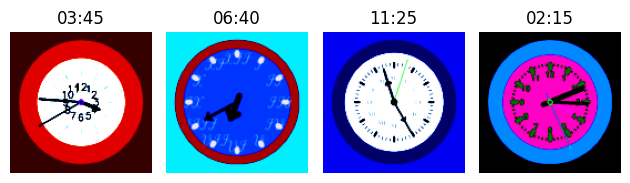

In [185]:
images, labels = next(iter(train_loader))
fig, ax = plt.subplots(1, 4)
for idx, (image, label) in enumerate(zip(images[0:4], labels[0:4])):
    ax[idx].imshow(image.permute(1, 2, 0).clamp(0, 1))
    ax[idx].set_axis_off()
    ax[idx].set_title(
        ":".join(map(lambda x: str(int(x)).rjust(2, "0"), label.tolist()))
    )
    fig.tight_layout()

In [186]:
import torch.nn as nn


class ResidualBlock(torch.nn.Module):
    def __init__(self, conv_block_1, conv_block_2, conv_block_3, activation):
        super(ResidualBlock, self).__init__()
        self.conv1 = conv_block_1
        self.conv2 = conv_block_2
        self.conv3 = conv_block_3
        self.activation = activation

    def forward(self, x):
        x_copy = x.clone()
        x = self.conv1(x)
        x = self.activation(x)
        x = self.conv2(x)
        x = self.activation(x)
        x = self.conv3(x)
        x = self.activation(x)
        x = x + x_copy
        x = self.activation(x)
        return x


relu = torch.nn.ReLU()


class ClockPredictor(torch.nn.Module):
    def __init__(self, device):
        super(ClockPredictor, self).__init__()
        self.device = device
        self.main = torch.nn.Sequential(
            # 128x128
            torch.nn.Conv2d(
                in_channels=3, out_channels=32, kernel_size=3, stride=1, padding="same"
            ),
            relu,
            torch.nn.BatchNorm2d(32),
            torch.nn.Conv2d(
                in_channels=32, out_channels=32, kernel_size=3, stride=1, padding="same"
            ),
            relu,
            torch.nn.BatchNorm2d(32),
            torch.nn.MaxPool2d(kernel_size=2, stride=2),  # 64x64
            torch.nn.Conv2d(
                in_channels=32, out_channels=64, kernel_size=3, stride=1, padding="same"
            ),
            relu,
            torch.nn.BatchNorm2d(64),
            torch.nn.Conv2d(
                in_channels=64, out_channels=64, kernel_size=3, stride=1, padding="same"
            ),
            relu,
            torch.nn.BatchNorm2d(64),
            torch.nn.MaxPool2d(kernel_size=2, stride=2),  # 32x32
            torch.nn.Conv2d(
                in_channels=64,
                out_channels=128,
                kernel_size=3,
                stride=1,
                padding="same",
            ),
            relu,
            torch.nn.BatchNorm2d(128),
            torch.nn.Conv2d(
                in_channels=128,
                out_channels=128,
                kernel_size=3,
                stride=1,
                padding="same",
            ),
            relu,
            torch.nn.BatchNorm2d(128),
            torch.nn.MaxPool2d(kernel_size=2, stride=2),  # 16x16
            torch.nn.Conv2d(
                in_channels=128,
                out_channels=256,
                kernel_size=3,
                stride=1,
                padding="same",
            ),
            relu,
            torch.nn.BatchNorm2d(256),
            torch.nn.Conv2d(
                in_channels=256,
                out_channels=256,
                kernel_size=3,
                stride=1,
                padding="same",
            ),
            relu,
            torch.nn.BatchNorm2d(256),
            torch.nn.MaxPool2d(kernel_size=2, stride=2),  # 8x8
            torch.nn.Flatten(),
            torch.nn.Linear(8 * 8 * 256, 128),
            relu,
            torch.nn.Linear(128, 32),
            relu,
            torch.nn.Linear(32, 2),
            torch.nn.Sigmoid(),
        ).to(self.device)

    def forward(self, x):
        x = self.main(x)
        x = x * torch.tensor((23, 59), dtype=torch.float32, device=self.device)
        return x


model = ClockPredictor("mps")

Test the model's output matches the expected shape (2 values, an hour and a minute)

In [187]:
imgs, labels = next(iter(train_loader))
model(imgs.to("mps")).shape, labels.shape

(torch.Size([8, 2]), torch.Size([8, 2]))

In [188]:
clock_loss = torch.nn.L1Loss()
clock_optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
num_epochs = 30
model.train()
total_losses = []
test_metrics = []
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for i, (images, labels) in enumerate(train_loader):
        output = model(images.to("mps"))
        loss = clock_loss(output, labels.to("mps"))
        clock_optimizer.zero_grad()
        loss.backward()
        clock_optimizer.step()
        total_loss += loss
    print("Total training loss over epoch {}: {:.2f}".format(epoch + 1, total_loss))
    total_losses.append(total_loss.item())
    model.eval()
    imgs, labels = next(iter(test_loader))
    output = model(imgs.to("mps"))
    mins_since_midnight_true = [(item[0] * 60 + item[1]).item() for item in labels]
    mins_since_midnight_pred = [(item[0] * 60 + item[1]).item() for item in output]

    diffs = [
        abs(pred - true)
        for pred, true in zip(mins_since_midnight_pred, mins_since_midnight_true)
    ]
    print(
        f"Median absolute error on the test set is {round(np.median(diffs), 3)} minutes"
    )
    test_metrics.append(round(np.median(diffs), 3))

Total training loss over epoch 1: 956.88
Median absolute error on the test set is 127.276 minutes
Total training loss over epoch 2: 775.04
Median absolute error on the test set is 123.39 minutes
Total training loss over epoch 3: 725.08
Median absolute error on the test set is 128.513 minutes
Total training loss over epoch 4: 594.81
Median absolute error on the test set is 143.188 minutes
Total training loss over epoch 5: 495.17
Median absolute error on the test set is 135.802 minutes
Total training loss over epoch 6: 417.94
Median absolute error on the test set is 118.489 minutes
Total training loss over epoch 7: 361.78
Median absolute error on the test set is 135.709 minutes
Total training loss over epoch 8: 327.10
Median absolute error on the test set is 119.221 minutes
Total training loss over epoch 9: 294.46
Median absolute error on the test set is 106.027 minutes
Total training loss over epoch 10: 260.92
Median absolute error on the test set is 113.597 minutes
Total training loss 

Text(0.5, 1.0, 'Median error on testing set (minutes)')

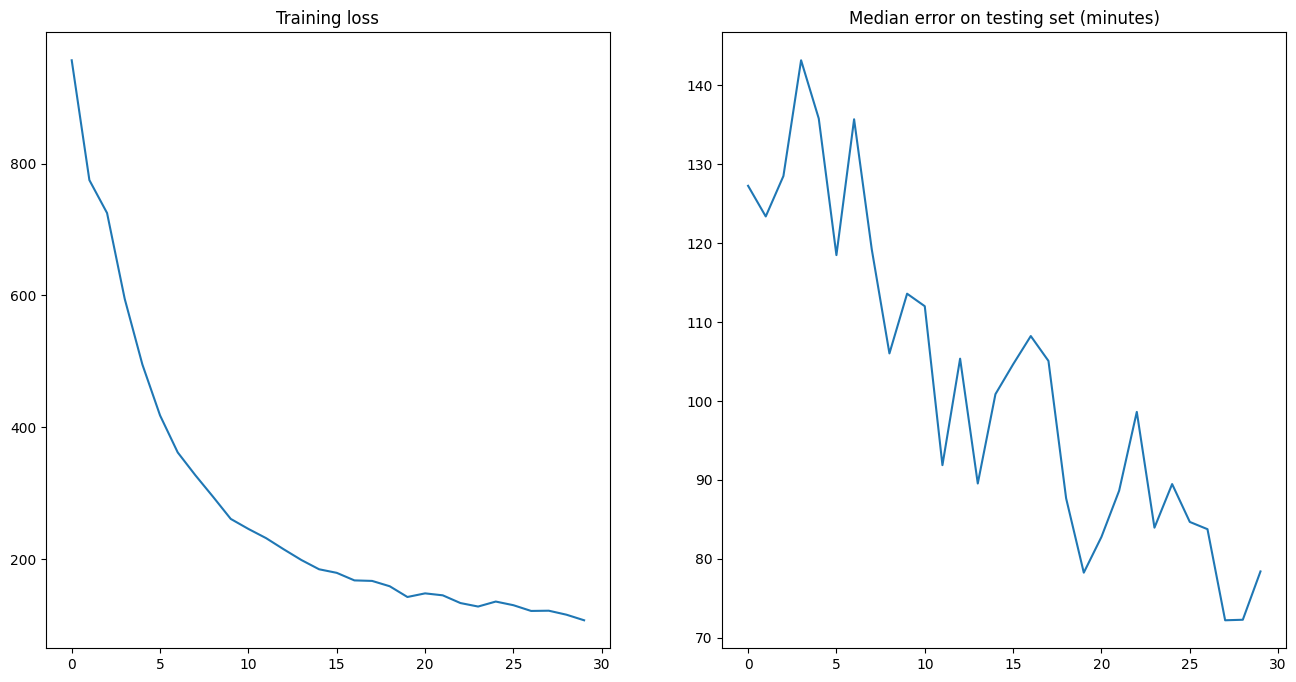

In [189]:
fig, (loss_plot, criterion_plot) = plt.subplots(1, 2, figsize=(16, 8))
loss_plot.plot(total_losses)
loss_plot.set_title("Training loss")
criterion_plot.plot(test_metrics)
criterion_plot.set_title("Median error on testing set (minutes)")

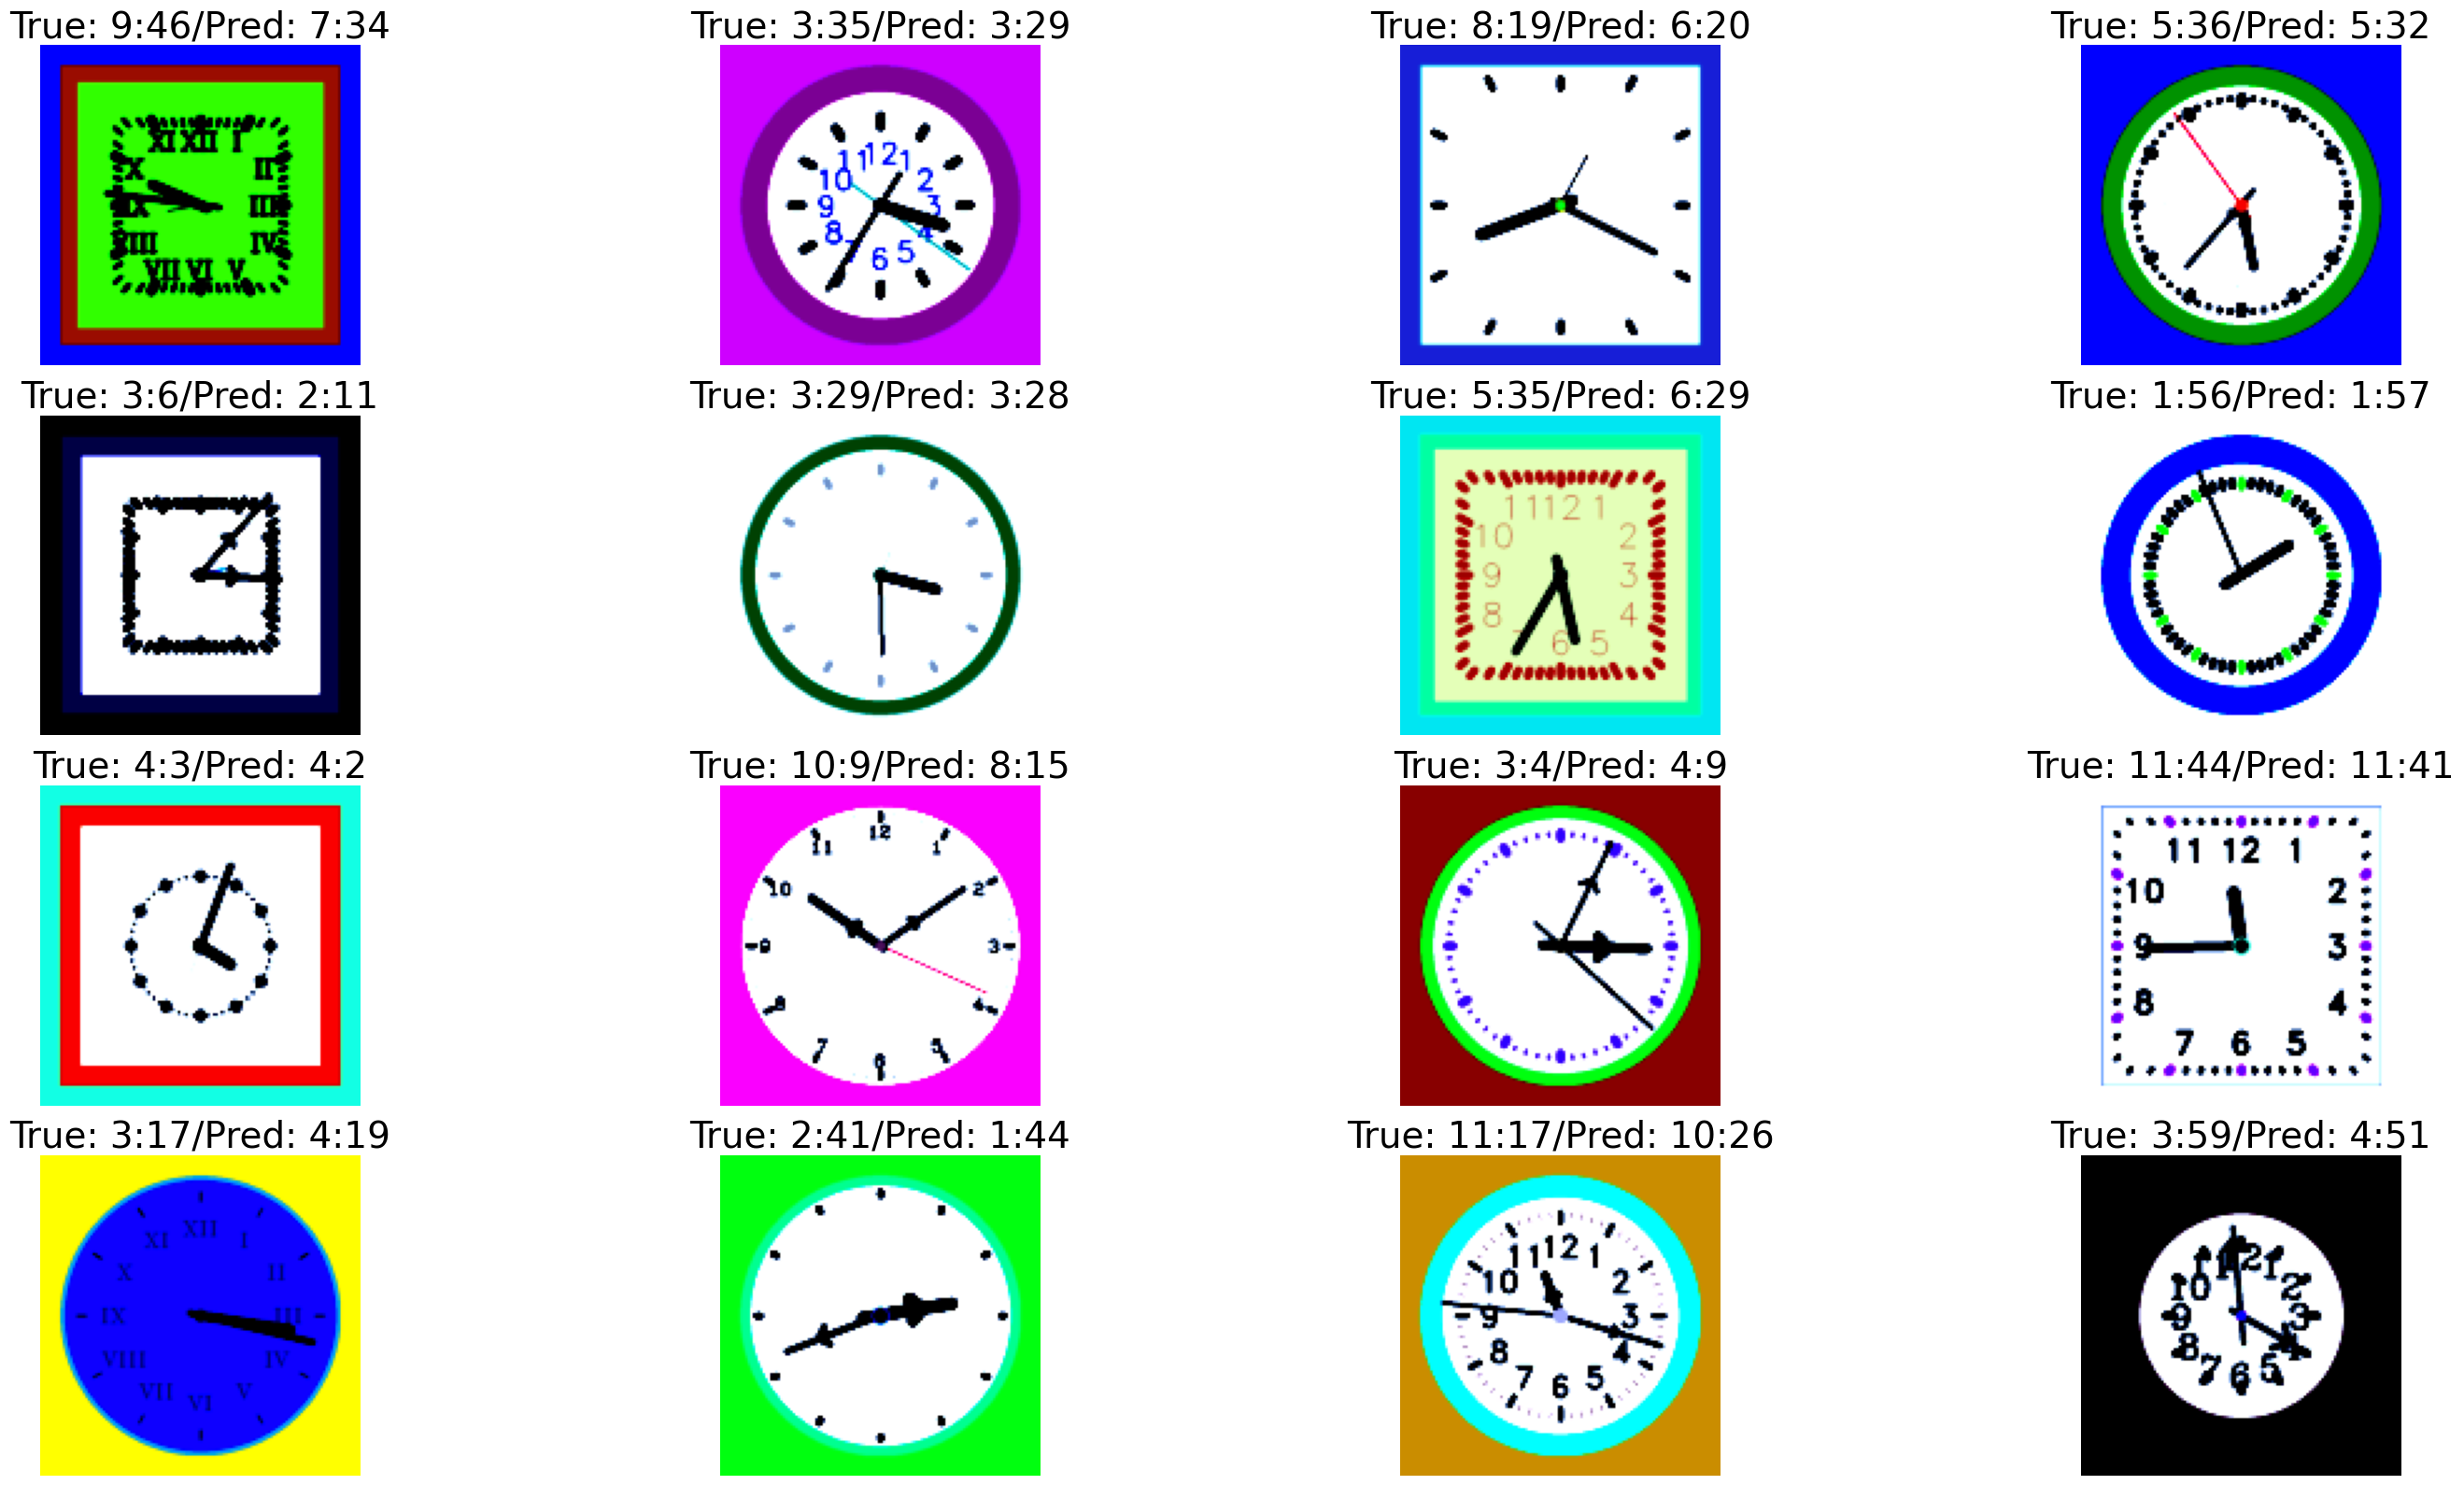

In [190]:
def minutes_from_midnignt_to_time(minutes):
    return f"{str(int(minutes // 60)).zfill(2)} : {str(int(minutes % 60)).zfill(2)}"


model.eval()
images, labels = next(iter(test_loader))
output = model(images.to("mps"))

# Display first 25 images with predicted labels
figure = plt.figure(figsize=(32, 16))
for i in range(16):
    figure.add_subplot(4, 4, i + 1)
    plt.title(
        "True: {}/Pred: {}".format(
            ":".join(list(map(lambda x: str(round(x)), labels[i].tolist()))),
            ":".join(list(map(lambda x: str(round(x)), output[i].tolist()))),
        ),
        fontsize=28,
    )
    plt.axis("off")
    plt.imshow(images[i, :].squeeze().clamp(0, 1).permute(1, 2, 0), cmap="gray")
figure.tight_layout()
plt.show()

In [191]:
torch.save(model.state_dict(), "q5-checkpoint.pt")

Get a feel for how the assesment criterion will look like - calculate the *median* error on the whole test set

In [193]:
imgs, labels = next(iter(test_loader))
output = model(imgs.to("mps"))
mins_since_midnight_true = [(item[0] * 60 + item[1]).item() for item in labels]
mins_since_midnight_pred = [(item[0] * 60 + item[1]).item() for item in output]

diffs = [
    abs(pred - true)
    for pred, true in zip(mins_since_midnight_pred, mins_since_midnight_true)
]
print(f"Median absolute error is {round(np.median(diffs), 3)} minutes")

Median absolute error is 78.39 minutes


%Latex
\pagebreak

# Question 6

No need to split training and testing data this time, train on entire dataset

In [162]:
batch_size = 10
nz = 150  # Size of z latent vector (i.e. size of generator input)
ngf = 128  # Size of feature maps in generator
ndf = 64  # Size of feature maps in discriminator
lr = 0.0002  # Learning rate for optimizers
beta1 = 0.5  # Beta1 hyperparam for Adam optimizers

In [129]:
import random


class AddGaussianNoise(object):
    def __init__(self, mean=0.0, std=1.0, probability=0.5, intensity=0.1):
        self.std = std
        self.mean = mean
        self.probability = probability
        self.intensity = intensity

    def __call__(self, tensor):
        return (
            tensor
            + (torch.randn(tensor.size()) * self.std + self.mean) * self.intensity
            if random.random() > self.probability
            else tensor
        )

    def __repr__(self):
        return self.__class__.__name__ + "(mean={0}, std={1})".format(
            self.mean, self.std
        )

In [163]:
transform = v2.Compose(
    [
        v2.Resize((64, 64)),
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
        v2.RandomChannelPermutation(),  # Safe (but slightly limited) way to augment hte data - we get a completely different colouring but hte same shape and hand positioning
        # AddGaussianNoise(0, 1, 0.5), # Add some noise to the image with a 0.5 probability
    ]
)
dataset = ClocksDataset("train", transform)
data_loader = DataLoader(dataset, batch_size=batch_size)

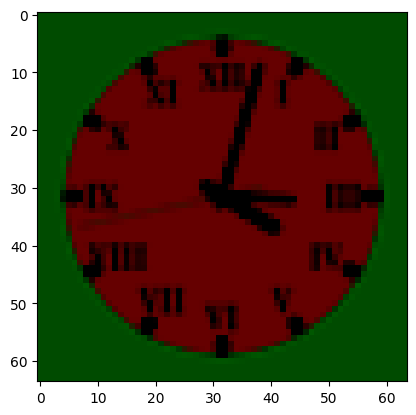

In [131]:
img, _ = dataset[0]
plt.imshow(img.permute(1, 2, 0).clamp(0, 1))

In [209]:
class Generator(torch.nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.LeakyReLU(True),
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.LeakyReLU(True),
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.LeakyReLU(True),
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.LeakyReLU(True),
            # nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            # nn.BatchNorm2d(ngf),
            # nn.LeakyReLU(True),
            nn.ConvTranspose2d(ngf, 3, 4, 2, 1, bias=False),
            nn.Tanh(),
        )

    def forward(self, input):
        return self.main(input)


netG = Generator()
netG = netG.to("mps")

env: PYTORCH_ENABLE_MPS_FALLBACK=1
torch.Size([3, 3, 64, 64])


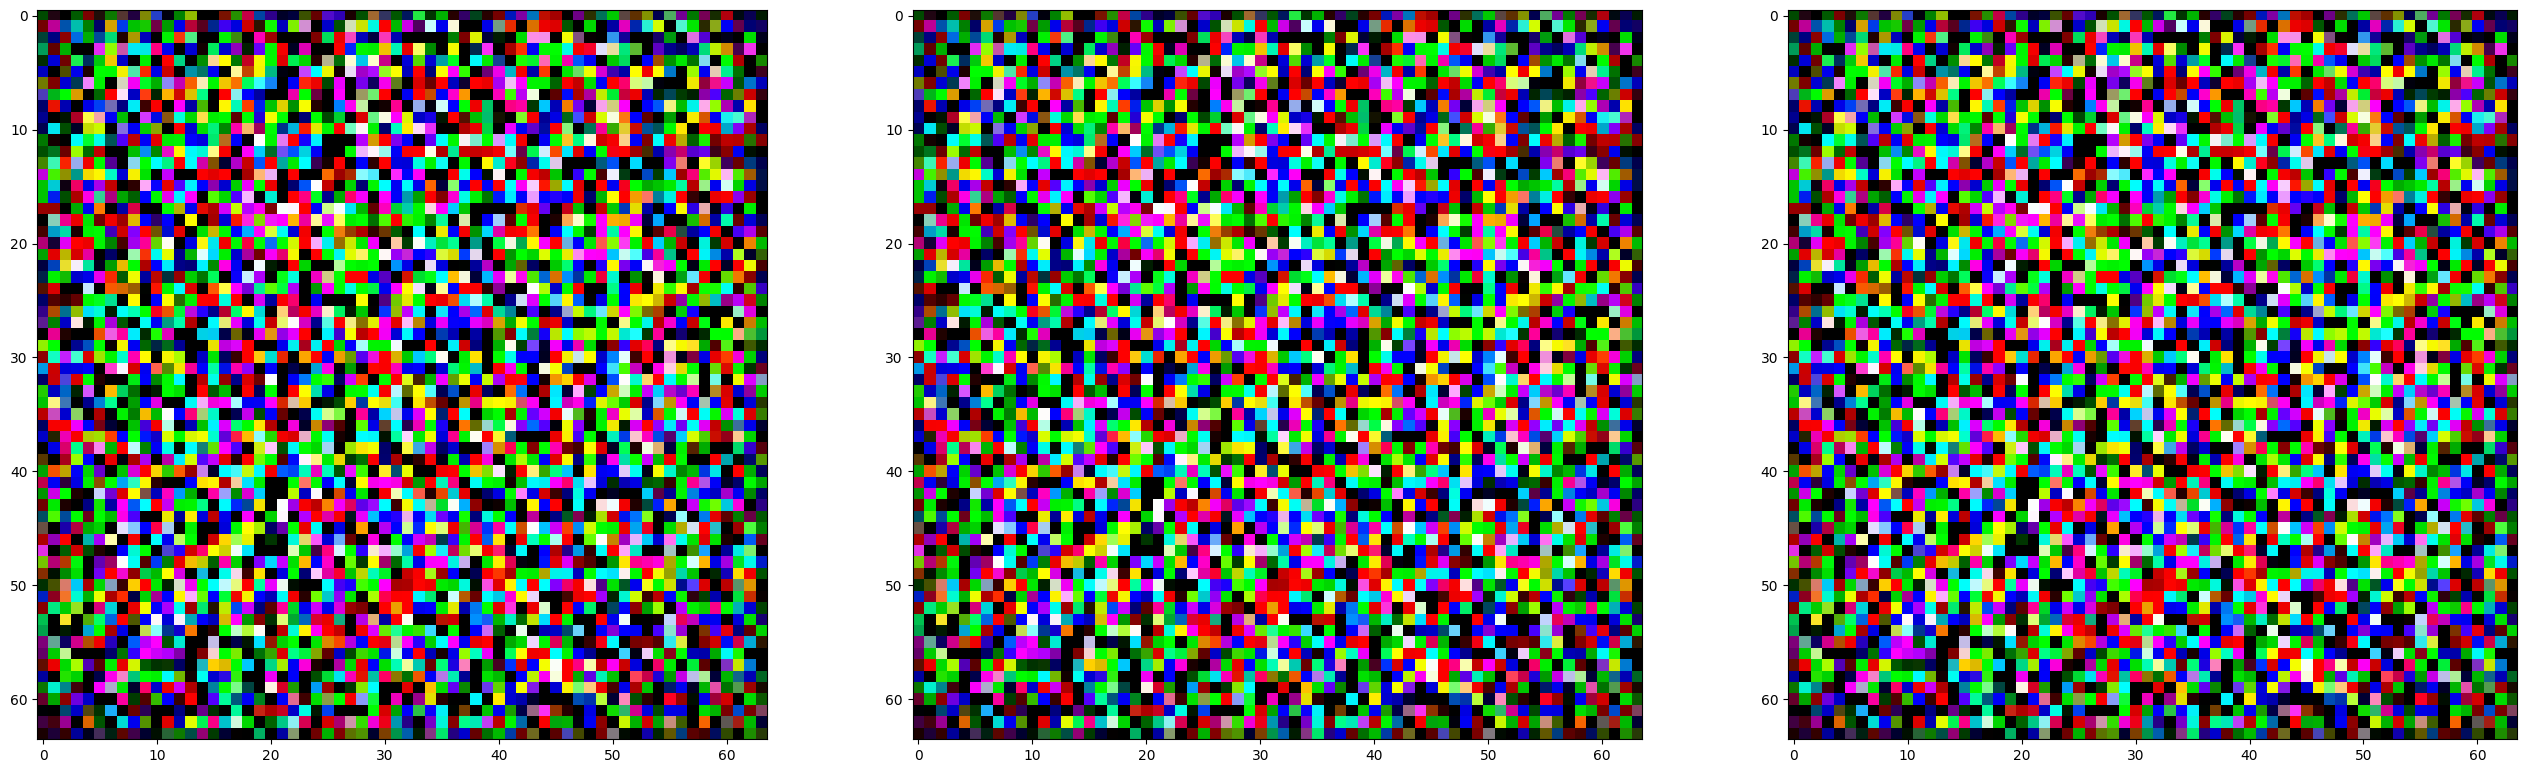

In [210]:
%env PYTORCH_ENABLE_MPS_FALLBACK=1
random_z = torch.randn(3, nz, 1, 1, dtype=torch.float32).to("mps")
random_out = netG(random_z)
print(random_out.shape)
fig, ax = plt.subplots(1, 3, figsize=(32, 32))
for idx, img in enumerate(random_out):
    ax[idx].imshow(
        img.squeeze(0).squeeze(0).permute(1, 2, 0).clamp(0, 1).cpu().detach().numpy()
    )

In [211]:
class Discriminator(torch.nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = torch.nn.Sequential(
            # input is ``(nc) x 64 x 64``
            nn.Conv2d(3, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf) x 32 x 32``
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*2) x 16 x 16``
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*4) x 8 x 8``
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # nn.Conv2d(ndf * 8, ndf * 8, 4, 2, 1, bias=False),
            # nn.BatchNorm2d(ndf * 8),
            # nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*8) x 4 x 4``
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid(),
        )

    def forward(self, input):
        return self.main(input)


netD = Discriminator()
netD = netD.to("mps")

In [212]:
random_z = torch.randn(1, nz, 1, 1).to("mps")
random_out = netG(random_z)
netD(random_out).shape

torch.Size([1, 1, 1, 1])

In [213]:
device = "mps"

In [203]:
def get_test_images(out_location):
    """
    Convenience function to produce 10 images from the current state of the network and store them at a given location
    :param out_location: where to store the images
    """
    fig, ax = plt.subplots(1, 10)
    z_batch = torch.randn(10, nz, 1, 1)
    images = netG(z_batch.to("mps"))
    for idx, image in enumerate(images):
        ax[idx].imshow(
            image.squeeze(0)
            .squeeze(0)
            .permute(1, 2, 0)
            .clamp(0, 1)
            .cpu()
            .detach()
            .numpy()
        )
        ax[idx].set_axis_off()
    fig.savefig(out_location)
    plt.show()

[1/40][0/1000]	Loss_D: 1.4439	Loss_G: 9.6075	D(x): 0.5588	D(G(z)): 0.5703 / 0.0001
[1/40][50/1000]	Loss_D: 0.7187	Loss_G: 2.4537	D(x): 0.8455	D(G(z)): 0.1014 / 0.0732
[1/40][100/1000]	Loss_D: 0.7051	Loss_G: 2.4672	D(x): 0.8879	D(G(z)): 0.1045 / 0.0737
[1/40][150/1000]	Loss_D: 0.8420	Loss_G: 1.7316	D(x): 0.7083	D(G(z)): 0.0465 / 0.1893
[1/40][200/1000]	Loss_D: 0.7635	Loss_G: 1.9484	D(x): 0.8778	D(G(z)): 0.2038 / 0.1628
[1/40][250/1000]	Loss_D: 0.8555	Loss_G: 2.2878	D(x): 0.9596	D(G(z)): 0.3124 / 0.0836
[1/40][300/1000]	Loss_D: 0.7909	Loss_G: 2.6527	D(x): 0.8363	D(G(z)): 0.1683 / 0.0737
[1/40][350/1000]	Loss_D: 0.8463	Loss_G: 2.1353	D(x): 0.7341	D(G(z)): 0.1571 / 0.1284
[1/40][400/1000]	Loss_D: 0.7367	Loss_G: 1.9180	D(x): 0.8503	D(G(z)): 0.1775 / 0.1304
[1/40][450/1000]	Loss_D: 0.7238	Loss_G: 2.4409	D(x): 0.9017	D(G(z)): 0.1996 / 0.0703
[1/40][500/1000]	Loss_D: 0.8281	Loss_G: 1.6062	D(x): 0.7599	D(G(z)): 0.1994 / 0.1840
[1/40][550/1000]	Loss_D: 0.7066	Loss_G: 2.7033	D(x): 0.8578	D(G(z)):

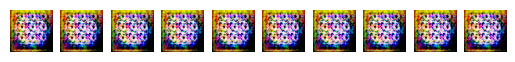

Saving model weights...
[2/40][0/1000]	Loss_D: 0.6704	Loss_G: 2.1281	D(x): 0.9190	D(G(z)): 0.1147 / 0.0991
[2/40][50/1000]	Loss_D: 0.7187	Loss_G: 2.0958	D(x): 0.8577	D(G(z)): 0.1399 / 0.1063
[2/40][100/1000]	Loss_D: 0.7406	Loss_G: 2.6290	D(x): 0.9248	D(G(z)): 0.2032 / 0.0585
[2/40][150/1000]	Loss_D: 0.6935	Loss_G: 2.1248	D(x): 0.8480	D(G(z)): 0.0614 / 0.1038
[2/40][200/1000]	Loss_D: 0.7144	Loss_G: 2.4940	D(x): 0.9308	D(G(z)): 0.0472 / 0.0713
[2/40][250/1000]	Loss_D: 0.7024	Loss_G: 2.7921	D(x): 0.8687	D(G(z)): 0.1127 / 0.0498


KeyboardInterrupt: 

In [214]:
# Initialize BCELoss function
criterion = nn.BCELoss()
num_epochs = 40  # Number of training epochs
# Establish convention for real and fake labels during training
real_label = 0.9
fake_label = 0.1

# Setup Adam optimizers for both G and D
optimizerD = torch.optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = torch.optim.Adam(netG.parameters(), lr=lr * 2, betas=(beta1, 0.999))
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, (images, labels) in enumerate(data_loader, 0):
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_images = images.to(device)
        label = torch.full(
            (batch_size,), real_label, dtype=torch.float32, device=device
        )
        # Forward pass real batch through D
        output = netD(real_images).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        z = torch.randn(batch_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(z)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()
        # Output training stats
        if i % 50 == 0:
            print(
                "[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f"
                % (
                    epoch + 1,
                    num_epochs,
                    i,
                    len(data_loader),
                    errD.item(),
                    errG.item(),
                    D_x,
                    D_G_z1,
                    D_G_z2,
                )
            )
    print("Saving test image...")
    get_test_images(f"wasserstein-loss/epoch-{epoch+1}-32-ngf.png")
    print("Saving model weights...")
    torch.save(
        netG.state_dict(), f"wasserstein-weights/netG-epoch-{epoch+1}-128-ngf.pt"
    )
    torch.save(netD.state_dict(), f"wasserstein-weights/netD-epoch-{epoch+1}-64-ngf.pt")

env: PYTORCH_ENABLE_MPS_FALLBACK=1
torch.Size([1, 3, 64, 64])


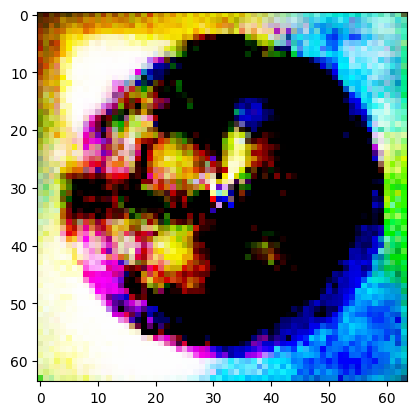

In [206]:
%env PYTORCH_ENABLE_MPS_FALLBACK=1
random_z = torch.rand(1, nz, 1, 1).to("mps")
random_out = netG(random_z)
print(random_out.shape)
plt.imshow(
    random_out.squeeze(0).squeeze(0).permute(1, 2, 0).clamp(0, 1).cpu().detach().numpy()
)

Generate 8 random clock images

In [ ]:
netG.load_state_dict(torch.load("q6-weights/netG-epoch-21.pt"))
netD.load_state_dict(torch.load("q6-weights/netD-epoch-21.pt"))

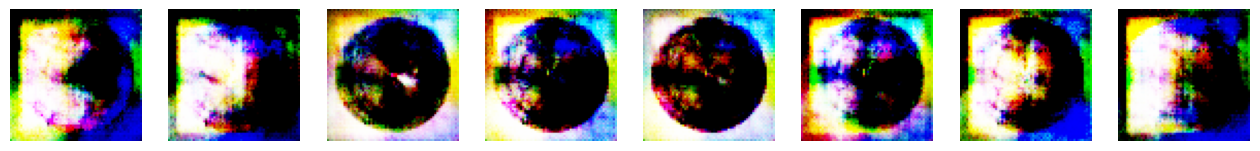

In [208]:
fig, ax = plt.subplots(1, 8, figsize=(16, 8))
for i in range(8):
    z = torch.rand(1, nz, 1, 1).to("mps")
    gen = netG(z)
    ax[i].axis("off")
    ax[i].imshow(
        gen.squeeze(0).squeeze(0).permute(1, 2, 0).clamp(0, 1).cpu().detach().numpy()
    )

## Linear interpolation demo

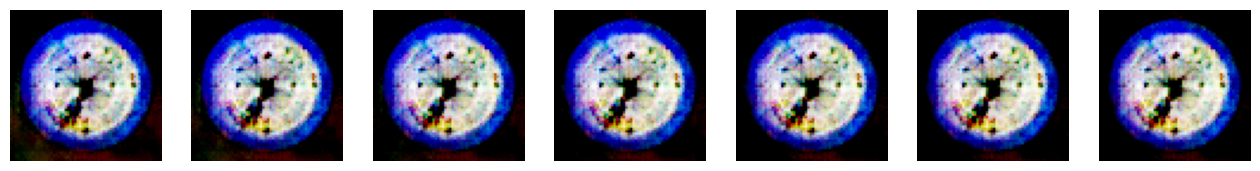

In [181]:
import numpy as np

fig, ax = plt.subplots(1, 7, figsize=(16, 8))
z1, z2 = torch.rand(1, nz, 1, 1).to("mps"), torch.rand(1, nz, 1, 1).to("mps")
intermediates = [z1]
for i in np.arange(1, 10, 2):
    intermediates.append((z1 * (1 - (i / 10))) + (z2 * (i / 10)))
intermediates.append(z2)

for idx, img in enumerate(intermediates):
    ax[idx].imshow(
        netG(img)
        .squeeze(0)
        .squeeze(0)
        .permute(1, 2, 0)
        .clamp(0, 1)
        .cpu()
        .detach()
        .numpy(),
    )
    ax[idx].axis("off")

In [ ]:
# torch.save(netG.state_dict(), "netG-ngf256-128x128-34-epochs.pt")
# torch.save(netD.state_dict(), "netD-ngf32-128x128-34-epochs.pt")